In [1]:
using Plots;
gadfly();

In [2]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

In [8]:
function simulate(n2, wavelength=160)
   
    #Global parameters
    size = 400;
    endTime = 5000;

    num_snaps = 250;
    snap_step = div(endTime, num_snaps);

    
    # Incident
    inc_pos = 50;

    # Material
    n1 = 1;
    n3 = 4;
    eps1 = n1^2;
    eps2 = n2^2;
    eps3 = n3^2;
    
    #wavelength = 160;
    q_wavelength = div(wavelength, (4*2))
    #q_wavelength = 20;
    #Grid

    # Magnetic
    hy = zeros(size-1);
    hy_0 = zeros(size-1);
    mu = ones(size-1);

    # Electric
    ez = zeros(size);
    ez_0 = zeros(size);
    eps = ones(size) * eps1;
    eps_0 = ones(size) * eps1;

    for i in div(size, 2):div(size, 2)+q_wavelength
        eps[i] = eps2;
    end
    for i in div(size, 2)+q_wavelength:size
        eps[i] = eps3;
    end

    
    rightBound = boundaries.setup_first_order_abc(eps, mu, size, true)
    leftBound = boundaries.setup_first_order_abc(eps, mu, 1, false)

    rightBound_0 = boundaries.setup_first_order_abc(eps_0, mu, size, true)
    leftBound_0 = boundaries.setup_first_order_abc(eps_0, mu, 1, false)

    # output params
    ez_snapshot = Array{Any}(num_snaps);
    ez_0_snapshot = Array{Any}(num_snaps);
    
    # Time steps
    for time in 1:endTime
        # Incident
        ez_inc = sin(2*pi/(wavelength) * (time-1))*exp(-500/time)

        # Magnetic      
        # Interior update
        update.update_magnetic_field!(ez, hy, mu);    
        update.update_magnetic_field!(ez_0, hy_0, mu);          
               
        # Electric     
        # Interior update
        update.update_electric_field!(ez, hy, eps);
        update.update_electric_field!(ez_0, hy_0, eps_0);    

        # ABC
        boundaries.first_order_diff_abc!(ez, leftBound)
        boundaries.first_order_diff_abc!(ez, rightBound)

        boundaries.first_order_diff_abc!(ez_0, leftBound_0)
        boundaries.first_order_diff_abc!(ez_0, rightBound_0)
        
        # Incident
        ez[inc_pos] += ez_inc / sqrt( eps[inc_pos] * mu[inc_pos])
        ez_0[inc_pos] += ez_inc / sqrt( eps_0[inc_pos] * mu[inc_pos])
        
        # Snapshots for animation
        if mod(time, snap_step) == 0
            ez_snapshot[div(time,snap_step)] = (time, copy(ez))
            ez_0_snapshot[div(time,snap_step)] = (time, copy(ez_0))
        end
        
    end
    return (ez-ez_0)[1:200]
    #return ez, ez_0, ez_snapshot, ez_0_snapshot
end

simulate (generic function with 2 methods)

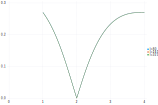

In [9]:
ran = linspace(1, 4, 100);
refl = zeros(100);
for i in 1:100
    h = simulate(ran[i], 80);
    refl[i] = maximum(abs(h))
end

plot(ran, refl, lab="l=80")

refl = zeros(100);
for i in 1:100
    h = simulate(ran[i], 160);
    refl[i] = maximum(abs(h))
end
plot!(ran, refl, lab="l=160")

refl = zeros(100);
for i in 1:100
    h = simulate(ran[i], 320);
    refl[i] = maximum(abs(h))
end
plot!(ran, refl, lab="l=320")

In [10]:
f_min = 1.
n_fdtd = -1
for i in 1:100
    if refl[i] < f_min
        f_min = refl[i]
        n_fdtd = ran[i]
    end
end

n_analytic = 2.

err = (abs(n_fdtd - n_analytic)/n_analytic) * 100
        
print("FDTD n = $n_fdtd\n")
print("Analtyic n = $n_analytic\n")
print("Error = $err%\n")
print("Max refl amplitude = $f_min")

FDTD n = 2.0
Analtyic n = 2.0
Error = 0.0%
Max refl amplitude = 0.0006899465067389254